# ROC曲線の作り方

### データの読み込み

In [1]:
import pandas as pd

# がんデータ
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                header=None)

### ラベリング

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

print(y[:5])
print(y[-5:])

le = LabelEncoder()
y = le.fit_transform(y)

print(y[:5])
print(y[-5:])

print(le.classes_)
print(le.transform(le.classes_))

['M' 'M' 'M' 'M' 'M']
['M' 'M' 'M' 'M' 'B']
[1 1 1 1 1]
[1 1 1 1 0]
['B' 'M']
[0 1]


### データセットの作成

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

print(X_train[:2, :])
print(y_train[:2])

[[1.291e+01 1.633e+01 8.253e+01 5.164e+02 7.941e-02 5.366e-02 3.873e-02
  2.377e-02 1.829e-01 5.667e-02 1.942e-01 9.086e-01 1.493e+00 1.575e+01
  5.298e-03 1.587e-02 2.321e-02 8.420e-03 1.853e-02 2.152e-03 1.388e+01
  2.200e+01 9.081e+01 6.006e+02 1.097e-01 1.506e-01 1.764e-01 8.235e-02
  3.024e-01 6.949e-02]
 [1.405e+01 2.715e+01 9.138e+01 6.004e+02 9.929e-02 1.126e-01 4.462e-02
  4.304e-02 1.537e-01 6.171e-02 3.645e-01 1.492e+00 2.888e+00 2.984e+01
  7.256e-03 2.678e-02 2.071e-02 1.626e-02 2.080e-02 5.304e-03 1.530e+01
  3.317e+01 1.002e+02 7.067e+02 1.241e-01 2.264e-01 1.326e-01 1.048e-01
  2.250e-01 8.321e-02]]
[0 0]


### 学習モデルと検証の準備

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2', random_state=1, C=100.0))

print("X_train shape", X_train.shape)
print("y_train_y shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# 学習データを3分割にして、indexを確認
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
print(cv)

X_train shape (455, 30)
y_train_y shape (455,)
X_test shape (114, 30)
y_test shape (114,)
[(array([143, 145, 147, 148, 150, 152, 153, 154, 155, 156, 158, 159, 161,
       163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
       256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294,
       295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
       308, 309, 310, 311, 312, 313, 314, 31

### ROC曲線

/Users/inoueshinichi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/inoueshinichi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/inoueshinichi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


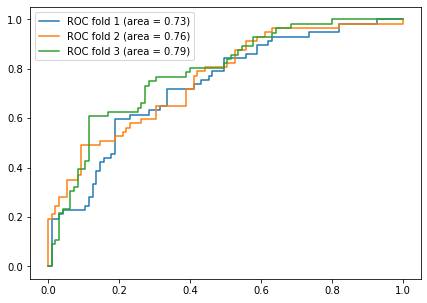

In [13]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 4番目と14番目の特徴量だけを学習データに使用する
X_train2 = X_train[:, [4, 14]]

mean_tpr = 0.0 # 真陽性
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

fig = plt.figure(figsize=(7, 5))
for i, (train, test) in enumerate(cv):
    fitedModel = pipe_lr.fit(X_train2[train], y_train[train])
    
    # 予測確率
    probas = fitedModel.predict_proba(X_train2[test])
    #print(probas[0, :]) 
    
    # 偽陽性, 真陽性, 判断しきい値
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr) # FPR(X軸)とTPR(Y軸)を線形補間
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
plt.legend()
plt.show()